In [1]:
import os
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# entropy calculation
from entropy.entropy import EntropyCalculator
entropy_calculator = EntropyCalculator()
def mi_matrix(output_spikes, input_spikes):
    """
    Calculate the mutual information of the model.
    Calculation includes the MI for each output neuron and the overall MI of the model.
    
    Formula: I(S;R) = ∑p(s,r) log(p(s,r)/(p(s)p(r)))
    
    where:
        - S is the input spikes
        - R is the output spikes
        - p(s,r) is the joint probability of input and output spikes
        - p(s) is the marginal probability of input spikes
        - p(r) is the marginal probability of output spikes

    Args:
        output_spikes (list): Spikes from the output layer.
        input_spikes (list): Spikes from the input layer.

    Returns:
        np.ndarray: List of MI (neuron0, neuron1, overall).
    """
    output_spikes = np.array(output_spikes)
    input_spikes = np.array(input_spikes)

    mi = []

    for input_spike in input_spikes:
        if not isinstance(input_spike, np.ndarray):
            raise ValueError("Input spikes must be a numpy array.")
        
        for output_spike in output_spikes:
            if not isinstance(output_spike, np.ndarray):
                raise ValueError("Output spikes must be a numpy array.")
            mi.append(entropy_calculator.mutual_information(input_spike, output_spike))

    return np.mean(np.asarray(mi), axis=0)

def hc_matrix(output_spikes, input_spikes):
    """
    Calculate the conditional entropy of the model.
    Calculation includes the conditional entropy for each output neuron and the overall conditional entropy of the model.
    
    Formula: H(R|S) = -∑p(s)∑p(r|s) log(p(r|s))
    
    Args:
        output_spikes (list): Spikes from the output layer.
        input_spikes (list): Spikes from the input layer.

    Returns:
        np.ndarray: List of entropies (neuron0, neuron1, overall).
    """
    output_spikes = np.array(output_spikes)
    input_spikes = np.array(input_spikes)
    
    hc = []
    
    for input_spike in input_spikes:
        if not isinstance(input_spike, np.ndarray):
            raise ValueError("Input spikes must be a numpy array.")

        for output_spike in output_spikes:
            if not isinstance(output_spike, np.ndarray):
                raise ValueError("Output spikes must be a numpy array.")

            hc.append(entropy_calculator.conditional_entropy(output_spike, input_spike))

    return np.mean(np.asarray(hc), axis=0)


In [3]:
def load_npz_folder(folder, x_key="x", label_key="label", C=None, T=None, strict=False):
    files = sorted(folder.glob("*.npz"))
    if not files: raise FileNotFoundError(f"No .npz files in {folder}")
    X, y = [], []
    for f in files:
        data = np.load(f, allow_pickle=False)
        if x_key not in data or label_key not in data:
            print(f"[WARN] Skip {f.name}: missing keys"); continue
        x = data[x_key]; lbl = data[label_key]
        lbl = int(lbl) if not isinstance(lbl, np.ndarray) else int(np.ravel(lbl)[0])
        if x.ndim != 2:
            print(f"[WARN] Skip {f.name}: x must be 2D (C,T), got {x.shape}"); continue
        Cx, Tx = x.shape
        if strict and ((C is not None and Cx != C) or (T is not None and Tx != T)):
            print(f"[WARN] Skip {f.name}: expected ({C},{T}), got {x.shape}"); continue
        X.append(x.astype(np.int8)); y.append(lbl)
    if not X: raise RuntimeError("No valid samples loaded.")
    X, y = np.array(X, dtype=np.int8), np.array(y, dtype=int)
    if C is None or T is None: C, T = X.shape[1], X.shape[2]
    return X, y, int(C), int(T)

def spikes_from_matrix(binmat, dt_ms):
    ch, t = np.where(binmat > 0)
    if ch.size == 0: return np.array([], dtype=int), np.array([], dtype=float)
    times_ms = (t.astype(np.float64) * dt_ms)
    return ch.astype(int), times_ms

def make_balanced_splits(y, train_split, val_split, balance_val, rng):
    n = len(y)
    idx0 = np.where(y==0)[0]
    idx1 = np.where(y==1)[0]
    rng.shuffle(idx0); rng.shuffle(idx1)

    # desired validation size
    n_val_total = int(np.floor(val_split * n))
    if balance_val:
        n_val_per = min(len(idx0), len(idx1), n_val_total//2)
        val_idx = np.concatenate([idx0[:n_val_per], idx1[:n_val_per]])
        idx0 = idx0[n_val_per:]; idx1 = idx1[n_val_per:]
    else:
        n_val0 = int(round(n_val_total * len(idx0)/(len(idx0)+len(idx1))))
        n_val1 = n_val_total - n_val0
        val_idx = np.concatenate([idx0[:n_val0], idx1[:n_val1]])
        idx0 = idx0[n_val0:]; idx1 = idx1[n_val1:]

    remaining = np.concatenate([idx0, idx1])
    rng.shuffle(remaining)

    n_train_total = int(np.floor(train_split * n))
    n_train_total = min(n_train_total, len(remaining))
    train_idx = remaining[:n_train_total]
    rest = remaining[n_train_total:]

    rng.shuffle(train_idx); rng.shuffle(val_idx)
    return train_idx.astype(int), val_idx.astype(int)

def predict_spike_count(counts):
    return int(np.argmax(counts))

# Info metrics on margin M from counts
def entropy(p):
    p = p[np.isfinite(p) & (p > 0)]
    return float(-np.sum(p * np.log2(p))) if p.size > 0 else 0.0

def info_from_counts_margins(
    n0_list,
    n1_list,
    y_list,
    bin=21,
    ep=1e-12
):
    n0 = np.asarray(n0_list, dtype=float)
    n1 = np.asarray(n1_list, dtype=float)
    y = np.asarray(y_list, dtype=float)
    
    m = (n1 - n0) / (n0 + n1 + ep)
    bins = np.linspace(-1, 1, bin + 1)
    
    #overall
    hist, _ = np.histogram(m, bins=bins)
    p = hist / max(1, hist.sum())
    H_M = entropy(p)
    
    # conditional
    Hc = 0.0
    for c in (0, 1):
        mc = m[y == c]
        if mc.size == 0: continue
        hc, _ = np.histogram(mc, bins=bins)
        pc = hc / max(1, hc.sum())
        Hc += (mc.size / len(m)) * entropy(pc)

    MI = H_M - Hc

    return H_M, Hc, MI

def build_network(C, dt_ms, params):
    Np = params['out_pop']; Nout = 2 * Np
    defaultclock.dt = dt_ms * ms

    # Input
    G_in = SpikeGeneratorGroup(C, indices=np.array([], dtype=int), times=np.array([])*ms, name='G_in')

    # Output neurons (LIF + ytrace), use tau_y (avoid '_post' naming conflict)
    eqs = '''
    dv/dt = (-v + ge - gi + Ibias) / tau_m : 1 (unless refractory)
    dge/dt = -ge / tau_e : 1
    dgi/dt = -gi / tau_i : 1
    dytrace/dt = -ytrace / tau_y : 1
    Ibias : 1
    tau_m : second
    tau_e : second
    tau_i : second
    tau_y : second
    v_th : 1
    Apost_out : 1
    '''
    G_out = NeuronGroup(2*Np, eqs,
                        threshold='v>v_th',
                        reset='v=0; ytrace += Apost_out',
                        refractory=params['refractory']*ms, method='euler',
                        name='outpop')
    G_out.tau_m = params['tau_mem'] * ms
    G_out.tau_e = params['tau_syn'] * ms
    G_out.tau_i = params['inh_tau'] * ms
    G_out.tau_y = params['tau_post'] * ms
    G_out.v_th = params['v_th']; G_out.Apost_out = params['Apost']; G_out.v = 0
    G_out.Ibias = params['i_bias']

    # In->Out synapses (eligibility, no '_post' variables defined here)
    S = Synapses(G_in, G_out,
                 model='''
                 w : 1
                 dxpre/dt = -xpre/taupre : 1 (clock-driven)
                 delig/dt = (-elig + k_elig * xpre * ytrace_post) / tau_elig : 1 (clock-driven)
                 taupre : second
                 tau_elig : second
                 k_elig : 1
                 Apre : 1
                 ''',
                 on_pre='''
                 ge_post += w
                 xpre += Apre
                 ''',
                 name='S_in_out')
    S.connect(True)
    rng = np.random.default_rng(params['seed'])
    S.w = rng.uniform(0.0, 0.3, size=len(S))
    S.taupre = params['tau_pre'] * ms
    S.tau_elig = params['tau_e'] * ms
    S.k_elig = params['k_elig']
    S.Apre = params['Apre']

    # Lateral inhibition
    S_inh = Synapses(G_out, G_out, on_pre='gi_post += w_inh', model='w_inh:1', name='S_inh')
    S_inh.connect(condition='i!=j'); S_inh.w_inh = params['inh_w']

    # Modulatory teacher (identity to outpop): bumps ytrace only
    G_teacher = SpikeGeneratorGroup(2*Np, indices=np.array([], dtype=int), times=np.array([])*ms, name='G_teacher')
    S_teach = Synapses(G_teacher, G_out, on_pre='ytrace_post += w_teach', model='w_teach:1', name='S_teach')
    S_teach.connect(j='i'); S_teach.w_teach = params['teacher_trace_w']

    # Monitors
    M_out = SpikeMonitor(G_out, name='M_out')

    net = Network(G_in, G_out, S, S_inh, G_teacher, S_teach, M_out)
    return net, G_in, G_out, S, M_out, G_teacher, Np

def train_and_eval(X, y, C, T, params):
    dt_ms = float(params['dt']) 
    Tdur_ms = T * dt_ms 
    gap_ms = float(params['gap'])

    rng = np.random.default_rng(params['seed'])
    n = len(X)

    train_idx, val_idx = make_balanced_splits(y, params['train_split'], params['val_split'], True, rng)

    # Split summary
    def _sum_idx(idx):
        return int(np.sum(y[idx]==0)), int(np.sum(y[idx]==1))
    tr0,tr1 = _sum_idx(train_idx); va0,va1 = _sum_idx(val_idx)
    print(f"[Split] Train: {len(train_idx)} (y0={tr0}, y1={tr1}) | Val: {len(val_idx)} (y0={va0}, y1={va1})")
    

    net, G_in, G_out, S, M_out, G_teacher, Np = build_network(C, dt_ms, params)
    Nout = 2 * Np

    def normalize_per_class():
        if not params['norm_per_class']: return
        for cls in range(Nout):
            idx_cls = np.where(S.j[:] == cls)[0]
            if idx_cls.size > 0:
                s = float(np.sum(S.w[idx_cls]))
                if s > 0:
                    S.w[idx_cls] = S.w[idx_cls] / s
                    
    def class_counts(t0, t1):
        mask = (M_out.t / ms >= t0) & (M_out.t / ms < t1)
        ids = np.array(M_out.i[mask], dtype=int)
        if ids.size == 0:
            return [0, 0]
        c0 = int(np.sum((ids >= 0) & (ids < Np)))
        c1 = int(np.sum((ids >= Np) & (ids < 2*Np)))
        return [c0, c1]
    
    def run_trial(
        binmat,
        label,
        do_teacher=False,
        log_spike=False
    ):
        t_now = float(defaultclock.t / ms)
        inds, time_ms = spikes_from_matrix(binmat, dt_ms)
        G_in.set_spikes(inds, (t_now + time_ms) * ms)
        
        # Teacher GAP
        if do_teacher and params['teacher']:
            t0, t1 = Tdur_ms, Tdur_ms + gap_ms
            time_row = np.linspace(t_now + t0, t_now + t1, num=params['teacher_nspike']).astype(float)
            group = np.arange(label * Np, (label + 1) * Np, dtype=int)
            teach_idx = np.repeat(group, len(time_row))
            teach_times = np.tile(time_row, len(group))
            G_teacher.set_spikes(teach_idx, teach_times * ms)
        else:
            G_teacher.set_spikes(np.array([], dtype=int), np.array([]) * ms)
        
        # Reset and run
        G_out.v = 0
        G_out.ge = 0
        G_out.gi = 0
        G_out.ytrace = 0
        t_start = t_now
        t_end = t_now + Tdur_ms
        net.run(Tdur_ms * ms, report=None)
        counts = class_counts(t_start, t_end)
        if gap_ms > 0:
            net.run(gap_ms * ms, report=None)
            
        logs = None
        if log_spike:
            mask = (M_out.t / ms >= t_start) & (M_out.t / ms < t_end)
            out_ids = np.array(M_out.i[mask], dtype=int)
            out_t_rel = np.array((M_out.t[mask] / ms) - t_start, dtype=float)

            bins = np.floor(out_t_rel / float(dt_ms) + 1e-9).astype(int)
            bins = np.clip(bins, 0, T-1)
            mat = np.zeros((Nout, T), dtype=int)
            np.add.at(mat, (out_ids, bins), 1)
            mat = (mat > 0).astype(int)

            logs = (mat, out_ids, out_t_rel, counts, label)
        return counts, logs

    train_acc_hist = []
    val_acc_hist = []
    entropy_hist = {
        "group_0": {
            "shannon_entropy": [],
            "entropy_rate": [],
            "mutual_information": [],
            "conditional_entropy": [],
            "avg_spike_count": []
            },
        "group_1": {
            "shannon_entropy": [],
            "entropy_rate": [],
            "mutual_information": [],
            "conditional_entropy": [],
            "avg_spike_count": []
            },
        "model": {
            "shannon_entropy": [],
            "entropy_rate": [],
            "mutual_information": [],
            "conditional_entropy": [],
            "avg_spike_count": []
        }
    }
    margin_entropy = {
        "H_M": [],
        "H_M_Y": [],
        "I_M_Y": []
    }
    for ep in range(params['epochs']):
        # Balance subset
        if params["epoch_samples"] and params["epoch_samples"] > 0:
            idx0 = train_idx[y[train_idx] == 0]
            idx1 = train_idx[y[train_idx] == 1]

            m = min(params["epoch_samples"] // 2, len(idx0), len(idx1))
            ep_idx = np.concatenate([rng.choice(idx0, m, replace=False), rng.choice(idx1, m, replace=False)])
            
            rng.shuffle(ep_idx)
        else:
            ep_idx = train_idx.copy()
            rng.shuffle(ep_idx)
        
        train_correct = 0
        train_total = 0
        W_epoch_start = S.w[:].copy() 

        for i in ep_idx:
            binmat, label = X[i], int(y[i])
            counts, logs = run_trial(binmat, label, do_teacher=True, log_spike=True)

            ids, t_rel = logs[1], logs[2]
            
            y_count = predict_spike_count(counts)

            train_correct += int(y_count == label)
            train_total += 1

            
            # Weighted early-spike margin (time constant 30 ms)
            tau_w = 30.0
            w0 = np.exp(-t_rel[ids < Np] / tau_w).sum()
            w1 = np.exp(-t_rel[ids >= Np] / tau_w).sum()
            w_lab = w0 if label==0 else w1
            w_oth = w1 if label==0 else w0
            total_w = max(1e-6, w0 + w1)
            margin = (w_lab - w_oth) / total_w
            R_mag = float(np.tanh(params['reward_beta'] * margin))
# [-1,1]
            
            r_vec = np.zeros(Nout, dtype=float)
            if params['anti_hebbian']:
                r_vec[:] = -R_mag
                r_vec[label * Np:(label + 1) * Np] = +R_mag
            else:
                r_vec[label * Np:(label + 1) * Np] = abs(R_mag)
            mod = r_vec[S.j[:]]

            S.w = clip(S.w + params['lr'] * (S.elig * mod), 0, params['wmax'])
            S.elig = 0 * S.elig
            normalize_per_class()

        train_acc = train_correct / max(1, train_total)
        dW_mean = float(np.mean(np.abs(S.w[:] - W_epoch_start)))
        train_acc_hist.append(train_acc)
        print(f"[Epoch {ep+1}/{params['epochs']}] Train acc: {train_acc:.3f} | Δw̄: {dW_mean:.4f} |")

        # ----- Validation (no teacher, no learning) -----
        val_correct = 0; val_total = 0
        val_entropy = {
            "group_0": {
                "shannon_entropy": [],
                "entropy_rate": [],
                "mutual_information": [],
                "conditional_entropy": [],
                "spike_count": []
            },
            "group_1": {
                "shannon_entropy": [],
                "entropy_rate": [],
                "mutual_information": [],
                "conditional_entropy": [],
                "spike_count": []
            },
            "model": {
                "shannon_entropy": [],
                "entropy_rate": [],
                "mutual_information": [],
                "conditional_entropy": [],
                "spike_count": []
            }
        }
        n0_list = []
        n1_list = []
        y_list = []
        for i_val in val_idx:
            binmat_v, label_v = X[i_val], int(y[i_val])
            
            counts_v, logs_v = run_trial(binmat_v, label_v, do_teacher=False, log_spike=True)
            
            # ids_v, t_rel_v = logs_v[1], logs_v[2]
            y_count_v = predict_spike_count(counts_v)
            val_correct += int(y_count_v == label_v); val_total += 1

            n0_list.append(int(counts_v[0]))
            n1_list.append(int(counts_v[1]))
            y_list.append(label_v)

            out_spike = logs_v[0]  # binary spike matrix
                
            # entropy for neuron population 0
            out_spike_0 = out_spike[0:Np, :].copy()
            val_entropy["group_0"]["shannon_entropy"].append(entropy_calculator.shannon_entropy(out_spike_0))
            val_entropy["group_0"]["entropy_rate"].append(entropy_calculator.entropy_rate(out_spike_0))
            val_entropy["group_0"]["mutual_information"].append(mi_matrix(out_spike_0, binmat_v))
            val_entropy["group_0"]["conditional_entropy"].append(hc_matrix(out_spike_0, binmat_v))
            val_entropy["group_0"]["spike_count"].append(counts_v[0])
            
            # entropy for neuron population 1
            out_spike_1 = out_spike[Np:Nout, :].copy()
            val_entropy["group_1"]["shannon_entropy"].append(entropy_calculator.shannon_entropy(out_spike_1))
            val_entropy["group_1"]["entropy_rate"].append(entropy_calculator.entropy_rate(out_spike_1))
            val_entropy["group_1"]["mutual_information"].append(mi_matrix(out_spike_1, binmat_v))
            val_entropy["group_1"]["conditional_entropy"].append(hc_matrix(out_spike_1, binmat_v))
            val_entropy["group_1"]["spike_count"].append(counts_v[1])
            
            # entropy for model
            val_entropy["model"]["shannon_entropy"].append(entropy_calculator.shannon_entropy(out_spike))
            val_entropy["model"]["entropy_rate"].append(entropy_calculator.entropy_rate(out_spike))
            val_entropy["model"]["mutual_information"].append(mi_matrix(out_spike, binmat_v))
            val_entropy["model"]["conditional_entropy"].append(hc_matrix(out_spike, binmat_v))
            val_entropy["model"]["spike_count"].append(np.sum(counts_v))

            # Advance by GAP to keep global time consistent
            net.run(gap_ms * ms, report=None)

        H_M, Hc, MI = info_from_counts_margins(n0_list, n1_list, y_list, bin=21, ep=1e-12)

        # Diagnostics on validation
        n0_arr = np.array(n0_list); n1_arr = np.array(n1_list); y_arr = np.array(y_list)
        eps = 1e-12
        m = (n1_arr - n0_arr) / (n0_arr + n1_arr + eps)
        no_spike = float(np.mean((n0_arr + n1_arr) == 0))
        m0 = float(np.mean(m[y_arr==0])) if np.any(y_arr==0) else np.nan
        m1 = float(np.mean(m[y_arr==1])) if np.any(y_arr==1) else np.nan
        print(f"           [Val diag] mean spikes: {np.mean(n0_arr+n1_arr):.1f} | no-spike%: {100*no_spike:.1f}% | mean M|y=0: {m0:.3f} | mean M|y=1: {m1:.3f}")
    
        margin_entropy["H_M"].append(H_M)
        margin_entropy["H_M_Y"].append(Hc)
        margin_entropy["I_M_Y"].append(MI)

        entropy_hist["group_0"]["shannon_entropy"].append(np.mean(val_entropy["group_0"]["shannon_entropy"]))
        entropy_hist["group_0"]["entropy_rate"].append(np.mean(val_entropy["group_0"]["entropy_rate"]))
        entropy_hist["group_0"]["mutual_information"].append(np.mean(val_entropy["group_0"]["mutual_information"]))
        entropy_hist["group_0"]["conditional_entropy"].append(np.mean(val_entropy["group_0"]["conditional_entropy"]))
        entropy_hist["group_0"]["avg_spike_count"].append(np.mean(val_entropy["group_0"]["spike_count"]))

        entropy_hist["group_1"]["shannon_entropy"].append(np.mean(val_entropy["group_1"]["shannon_entropy"]))
        entropy_hist["group_1"]["entropy_rate"].append(np.mean(val_entropy["group_1"]["entropy_rate"]))
        entropy_hist["group_1"]["mutual_information"].append(np.mean(val_entropy["group_1"]["mutual_information"]))
        entropy_hist["group_1"]["conditional_entropy"].append(np.mean(val_entropy["group_1"]["conditional_entropy"]))
        entropy_hist["group_1"]["avg_spike_count"].append(np.mean(val_entropy["group_1"]["spike_count"]))

        entropy_hist["model"]["shannon_entropy"].append(np.mean(val_entropy["model"]["shannon_entropy"]))
        entropy_hist["model"]["entropy_rate"].append(np.mean(val_entropy["model"]["entropy_rate"]))
        entropy_hist["model"]["mutual_information"].append(np.mean(val_entropy["model"]["mutual_information"]))
        entropy_hist["model"]["conditional_entropy"].append(np.mean(val_entropy["model"]["conditional_entropy"]))
        entropy_hist["model"]["avg_spike_count"].append(np.mean(val_entropy["model"]["spike_count"]))

        val_acc = val_correct / max(1, val_total)
        val_acc_hist.append(val_acc)
        print(f"           [Val] acc: {val_acc:.3f} on {val_total} samples")
    
    return {"train_acc_hist": train_acc_hist if train_acc_hist else None,
            "val_acc_hist": val_acc_hist if val_acc_hist else None,
            "entropy_hist": entropy_hist if entropy_hist else None,
            "margin_entropy": margin_entropy if margin_entropy else None,
            "n_train": int(len(train_idx)), "n_val": int(len(val_idx))}, S


In [32]:
# Parameter
params = {
    # Data
    "NPZ_DIR": Path("/Users/minhhieunguyen/Documents/Projects/Dissertation/Code/spike_data/sr1000"),
    "x_key": "spike_matrix",
    "label_key": "label",
    "channels": 32,
    "time": 100,
    "strict_shape": True,

    # Timing
    "dt": 1.0,
    "epochs": 20,
    "seed": 42,

    # Learning traces
    "lr": 0.01,
    "Apre": 1.0,
    "Apost": 1.0,
    "tau_pre": 80,
    "tau_post": 80,
    "tau_e": 600,
    "k_elig": 3.0,
    "wmax": 3.0,
    "decay": 0.001,
    "norm_per_class": True,

    # Neuron dynamics
    "out_pop": 32,
    "v_th": 0.55,
    "tau_mem": 20,
    "tau_syn": 12,
    "refractory": 5,
    "inh_w": 2.2,
    "inh_tau": 10,
    "i_bias": 0.06,

    # Scheduling
    "train_split": 0.85,
    "val_split": 0.15,
    "gap": 25,

    # Teacher
    "teacher": True,
    "teacher_trace_w": 1.5,
    "teacher_nspike": 12,

    # Reward and margin scaling
    "anti_hebbian": False,
    "margin_da": False,
    "reward_beta": 1.5,

    # Homeostasis
    "target_spike": 3.0,
    "th_adapt": 0.02,

    # Subset per epoch (balanced)
    "epoch_samples": 128,
}

In [33]:
X, y, C, T = load_npz_folder(params["NPZ_DIR"], params["x_key"], params["label_key"],
                                 C=params["channels"], T=params["time"], strict=params["strict_shape"])
print(f"Loaded {len(X)} samples, shape = ({C},{T}), labels 0/1")
prefs.codegen.target = 'numpy'
metrics, S = train_and_eval(X, y, C, T, params)
print(metrics)

INFO       No numerical integration method specified for group 'S_in_out', using method 'exact' (took 0.08s). [brian2.stateupdaters.base.method_choice]


Loaded 400 samples, shape = (32,100), labels 0/1
[Split] Train: 340 (y0=170, y1=170) | Val: 60 (y0=30, y1=30)
[Epoch 1/20] Train acc: 0.555 | Δw̄: 0.1226 |
           [Val diag] mean spikes: 46.4 | no-spike%: 0.0% | mean M|y=0: -0.700 | mean M|y=1: 0.078
           [Val] acc: 0.683 on 60 samples
[Epoch 2/20] Train acc: 0.570 | Δw̄: 0.0050 |
           [Val diag] mean spikes: 50.1 | no-spike%: 0.0% | mean M|y=0: -0.511 | mean M|y=1: -0.133
           [Val] acc: 0.600 on 60 samples
[Epoch 3/20] Train acc: 0.539 | Δw̄: 0.0060 |
           [Val diag] mean spikes: 45.3 | no-spike%: 0.0% | mean M|y=0: -0.667 | mean M|y=1: 0.067
           [Val] acc: 0.667 on 60 samples
[Epoch 4/20] Train acc: 0.602 | Δw̄: 0.0070 |
           [Val diag] mean spikes: 49.6 | no-spike%: 0.0% | mean M|y=0: -0.433 | mean M|y=1: 0.011
           [Val] acc: 0.650 on 60 samples
[Epoch 5/20] Train acc: 0.594 | Δw̄: 0.0068 |
           [Val diag] mean spikes: 42.7 | no-spike%: 0.0% | mean M|y=0: -0.611 | mean M|y=1: -0

In [34]:
train_acc_hist = metrics["train_acc_hist"]
val_acc_hist = metrics["val_acc_hist"]
group0_shannon_entropy = metrics["entropy_hist"]["group_0"]["shannon_entropy"]
group0_entropy_rate = metrics["entropy_hist"]["group_0"]["entropy_rate"]
group0_mutual_information = metrics["entropy_hist"]["group_0"]["mutual_information"]
group0_conditional_entropy = metrics["entropy_hist"]["group_0"]["conditional_entropy"]
group0_avg_spike_count = metrics["entropy_hist"]["group_0"]["avg_spike_count"]

group1_shannon_entropy = metrics["entropy_hist"]["group_1"]["shannon_entropy"]
group1_entropy_rate = metrics["entropy_hist"]["group_1"]["entropy_rate"]
group1_mutual_information = metrics["entropy_hist"]["group_1"]["mutual_information"]
group1_conditional_entropy = metrics["entropy_hist"]["group_1"]["conditional_entropy"]
group1_avg_spike_count = metrics["entropy_hist"]["group_1"]["avg_spike_count"]

model_shannon_entropy = metrics["entropy_hist"]["model"]["shannon_entropy"]
model_entropy_rate = metrics["entropy_hist"]["model"]["entropy_rate"]
model_mutual_information = metrics["entropy_hist"]["model"]["mutual_information"]
model_conditional_entropy = metrics["entropy_hist"]["model"]["conditional_entropy"]
model_avg_spike_count = metrics["entropy_hist"]["model"]["avg_spike_count"]

margin_H_M = metrics["margin_entropy"]["H_M"]
margin_H_M_Y = metrics["margin_entropy"]["H_M_Y"]
margin_I_M_Y = metrics["margin_entropy"]["I_M_Y"]

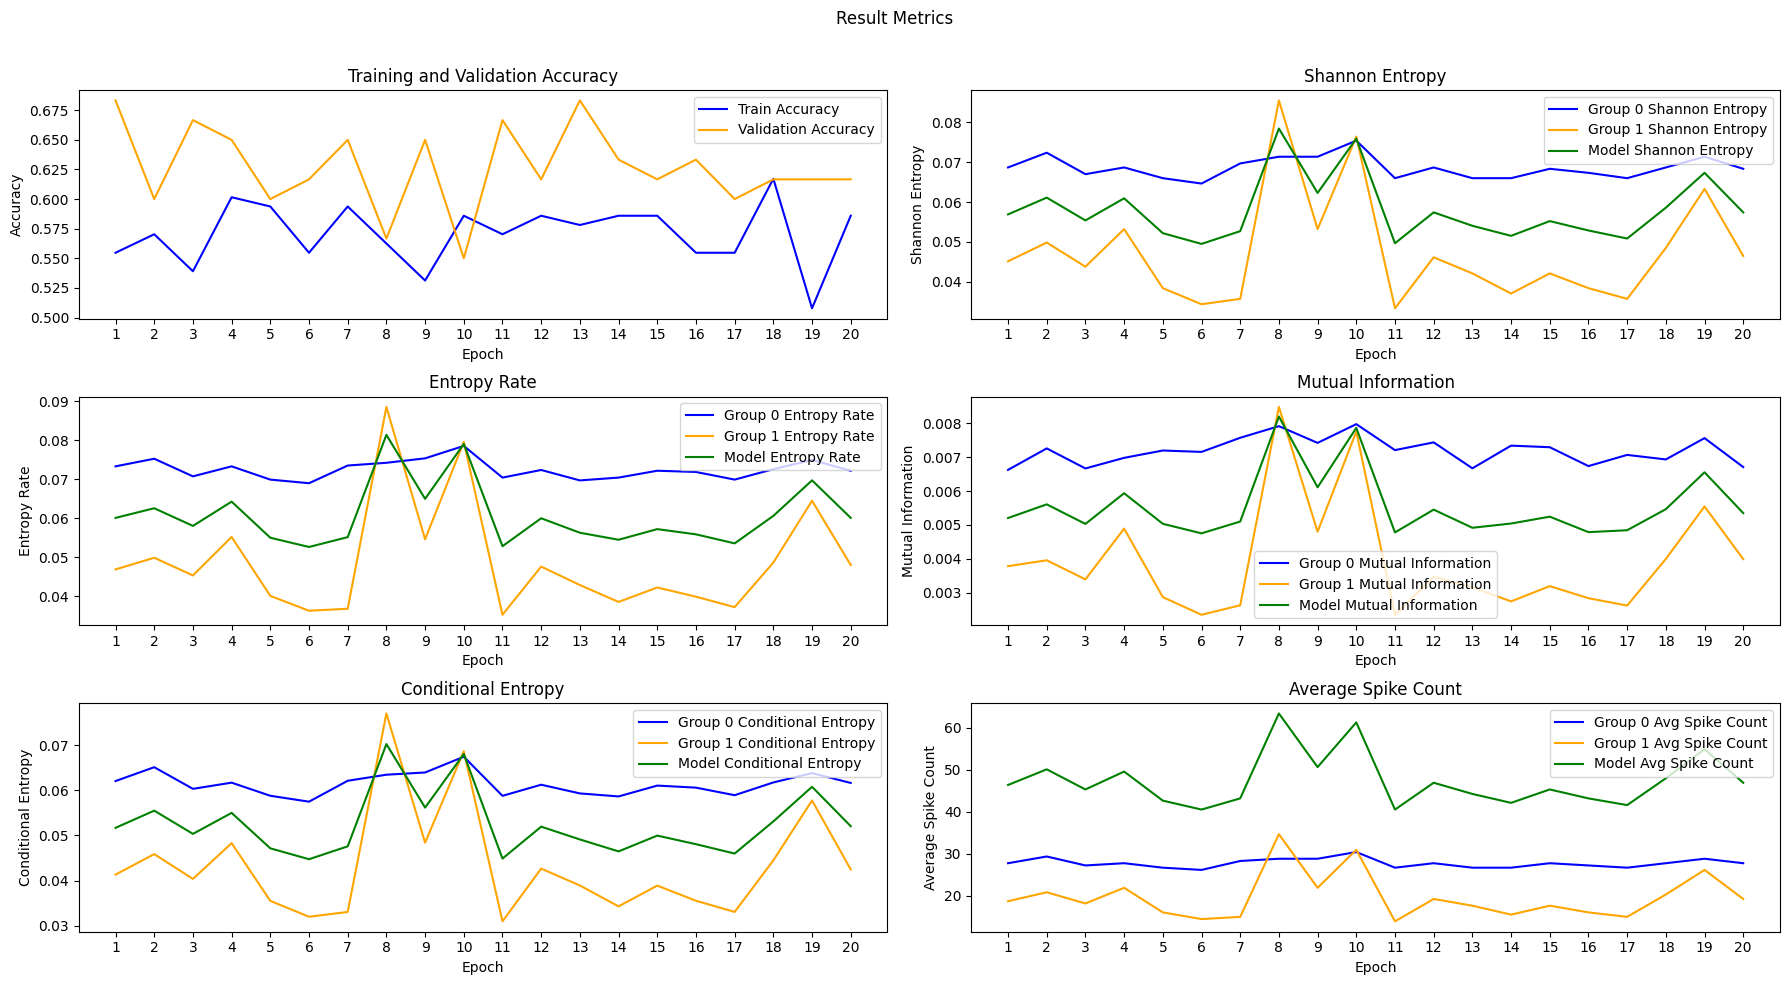

In [35]:
epoch_axis = np.arange(1, params["epochs"] + 1, 1)

# Plot the model results
plt.figure(figsize=(18, 10))

plt.subplot(3, 2, 1)
plt.plot(epoch_axis, train_acc_hist, label='Train Accuracy', color='blue')
plt.plot(epoch_axis, val_acc_hist, label='Validation Accuracy', color='orange')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(epoch_axis, group0_shannon_entropy, label='Group 0 Shannon Entropy', color='blue')
plt.plot(epoch_axis, group1_shannon_entropy, label='Group 1 Shannon Entropy', color='orange')
plt.plot(epoch_axis, model_shannon_entropy, label='Model Shannon Entropy', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(epoch_axis, group0_entropy_rate, label='Group 0 Entropy Rate', color='blue')
plt.plot(epoch_axis, group1_entropy_rate, label='Group 1 Entropy Rate', color='orange')
plt.plot(epoch_axis, model_entropy_rate, label='Model Entropy Rate', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Entropy Rate')
plt.title('Entropy Rate')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(epoch_axis, group0_mutual_information, label='Group 0 Mutual Information', color='blue')
plt.plot(epoch_axis, group1_mutual_information, label='Group 1 Mutual Information', color='orange')
plt.plot(epoch_axis, model_mutual_information, label='Model Mutual Information', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Mutual Information')
plt.title('Mutual Information')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(epoch_axis, group0_conditional_entropy, label='Group 0 Conditional Entropy', color='blue')
plt.plot(epoch_axis, group1_conditional_entropy, label='Group 1 Conditional Entropy', color='orange')
plt.plot(epoch_axis, model_conditional_entropy, label='Model Conditional Entropy', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Conditional Entropy')
plt.title('Conditional Entropy')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(epoch_axis, group0_avg_spike_count, label='Group 0 Avg Spike Count', color='blue')
plt.plot(epoch_axis, group1_avg_spike_count, label='Group 1 Avg Spike Count', color='orange')
plt.plot(epoch_axis, model_avg_spike_count, label='Model Avg Spike Count', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Average Spike Count')
plt.title('Average Spike Count')
plt.legend()

plt.suptitle('Result Metrics')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

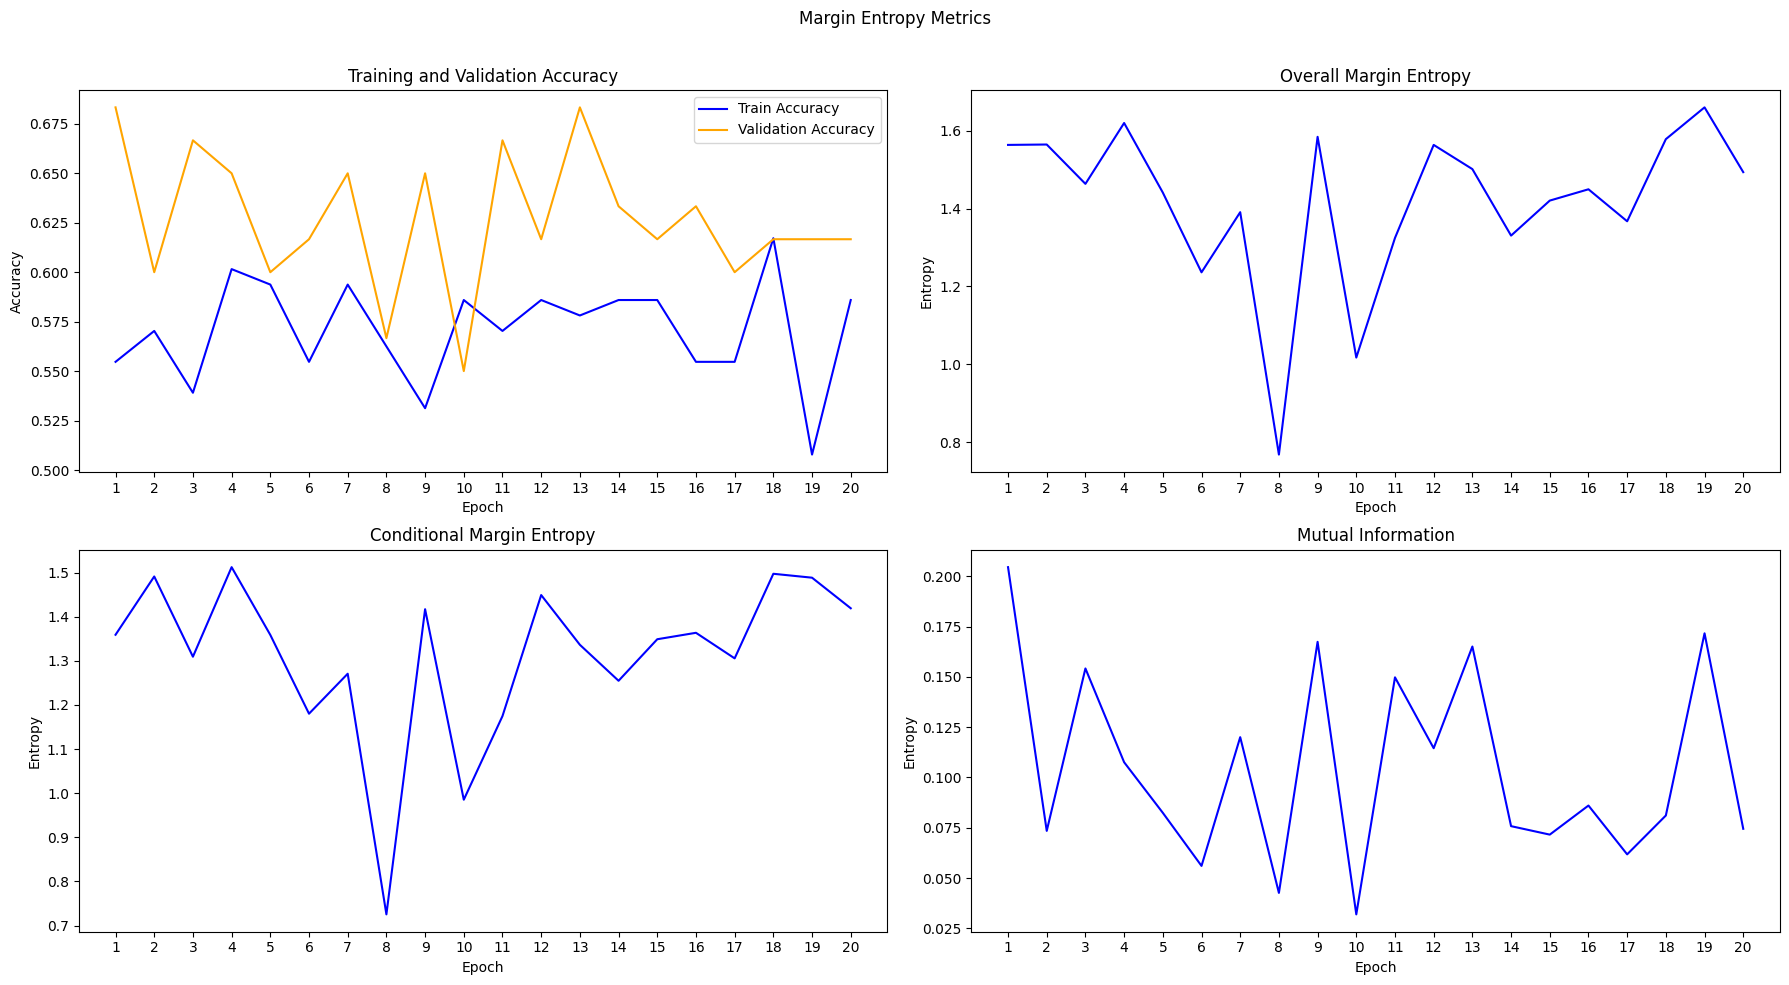

In [36]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(epoch_axis, train_acc_hist, label='Train Accuracy', color='blue')
plt.plot(epoch_axis, val_acc_hist, label='Validation Accuracy', color='orange')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epoch_axis, margin_H_M, label='H(M)', color='blue')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Overall Margin Entropy')

plt.subplot(2, 2, 3)
plt.plot(epoch_axis, margin_H_M_Y, label='H(M|Y)', color='blue')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Conditional Margin Entropy')

plt.subplot(2, 2, 4)
plt.plot(epoch_axis, margin_I_M_Y, label='I(M;Y)', color='blue')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Mutual Information')

plt.suptitle('Margin Entropy Metrics')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()